<a href="https://colab.research.google.com/github/UmrAsf/LungScanCNN/blob/main/CSEECNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = '/content/drive/My Drive/archive.zip'  # Replace with actual path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')  # Extracts contents to /content in Colab

In [3]:
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.8990 - auc: 0.9446 - loss: 0.2514 - val_accuracy: 0.9463 - val_auc: 0.9913 - val_loss: 0.1235
Epoch 2/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 2:28 1s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0433

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 65s 497ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0433 - val_accuracy: 0.9590 - val_auc: 0.9900 - val_loss: 0.1148
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.9576 - auc: 0.9883 - loss: 0.1192 - val_accuracy: 0.9521 - val_auc: 0.9906 - val_loss: 0.1107
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 81s 613ms/step - accuracy: 0.9688 - auc: 0.9732 - loss: 0.1459 - val_accuracy: 0.9521 - val_auc: 0.9917 - val_loss: 0.1140
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.9631 - auc: 0.9913 - loss: 0.0959 - val_accuracy: 0.9473 - val_auc: 0.9911 - val_loss: 0.1220
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 82s 620ms/step - accuracy: 0.9688 - auc: 0.9926 - loss: 0.0701 - val_accuracy: 0.9648 - val_auc: 0.9951 - val_loss: 0.0838
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.9622 - auc: 0.9925 - loss: 0.0947 - val_accuracy: 0.9521 - val_auc: 0.9927 - val_loss: 0.1225
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━

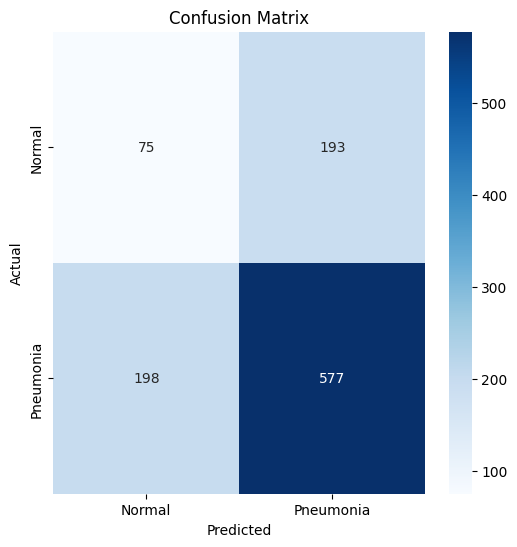

In [4]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the paths to the dataset directories
train_dir = '/content/chest_xray/train'  # Only using train_dir here

# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224  # MobileNetV2 input size
BATCH_SIZE = 32

# Set up data generator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=[1.2, 1.5],
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of training data as validation
)

# Load training and validation data using subset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load MobileNetV2 without the top layer for transfer learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model layers

# Add custom classification layers
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Dense layer
outputs = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name="auc")])

# Set up early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Calculate steps based on samples and batch size
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,  # Calculated based on batch size
    epochs=15,
    validation_data=val_generator,
    validation_steps=validation_steps,  # Calculated based on batch size
    callbacks=[early_stopping]
)


# Evaluate the model on test data (use val_generator if you don't have a separate test set)
test_loss, test_accuracy, test_auc = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {test_accuracy:.2f}, AUC: {test_auc:.2f}")

# Generate confusion matrix
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.round(y_pred).flatten()  # Threshold at 0.5 for binary classification

# Plot confusion matrix

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7464 - auc: 0.8329 - loss: 0.5120 - val_accuracy: 0.8789 - val_auc: 0.9547 - val_loss: 0.2933 - learning_rate: 1.0000e-05
Epoch 2/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 1:01 478ms/step - accuracy: 0.9375 - auc: 0.9960 - loss: 0.2724

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - accuracy: 0.9375 - auc: 0.9960 - loss: 0.2724 - val_accuracy: 0.8633 - val_auc: 0.9408 - val_loss: 0.3135 - learning_rate: 1.0000e-05
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.8793 - auc: 0.9610 - loss: 0.2708 - val_accuracy: 0.8838 - val_auc: 0.9603 - val_loss: 0.2563 - learning_rate: 1.0000e-05
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step - accuracy: 0.8750 - auc: 1.0000 - loss: 0.2461 - val_accuracy: 0.8857 - val_auc: 0.9639 - val_loss: 0.2531 - learning_rate: 1.0000e-05
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8971 - auc: 0.9707 - loss: 0.2251 - val_accuracy: 0.8887 - val_auc: 0.9636 - val_loss: 0.2413 - learning_rate: 1.0000e-05
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - accuracy: 0.8750 - auc: 0.9409 - loss: 0.2579 - val_accuracy: 0.9053 - val_auc: 0.9658 - val_loss: 0.2281 - learning_rate: 1.0000e-05
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accur

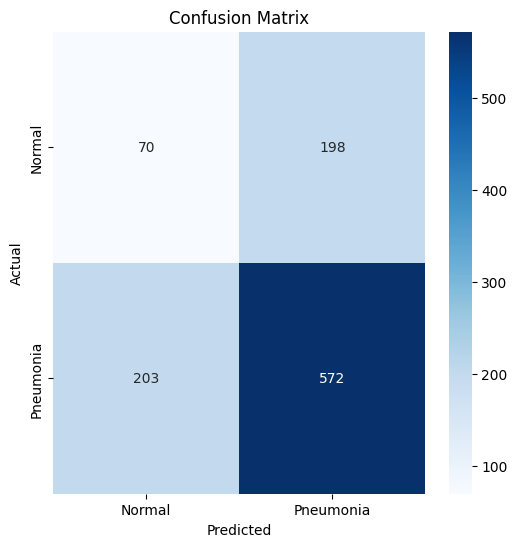

In [5]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the paths to the dataset directories
train_dir = '/content/chest_xray/train'

# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Using MobileNetV2 input size
BATCH_SIZE = 32

# Set up data generator with additional augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2  # 20% of training data as validation
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Calculate class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load MobileNetV2 without the top layer for transfer learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[:-10]:  # Adjust -10 based on available memory
    layer.trainable = False
base_model.trainable = True

# Add custom classification layers
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Dense layer
outputs = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

model = Model(inputs, outputs)

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name="auc")])

# Set up callbacks: Early Stopping and ReduceLROnPlateau
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,  # Change to a higher number if needed
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=class_weights,  # Apply class weights
    callbacks=[early_stopping, lr_schedule]
)

# Evaluate the model on validation data
val_loss, val_accuracy, val_auc = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.2f}, AUC: {val_auc:.2f}")

# Generate confusion matrix
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.round(y_pred).flatten()  # Threshold at 0.5 for binary classification

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [6]:
import os
print(os.listdir('/content/drive'))

['.shortcut-targets-by-id', 'MyDrive', '.Trash-0', '.Encrypted']
